<a href="https://colab.research.google.com/github/miladshiraniUCB/dsc-phase-3-project-from-kaggle/blob/main/Project_Phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To Do:

* USE FLAML


# Introduction

Heart Diesease is one of the main causes of death in the United State and there has been several researches to understand the how we can control and treat heart disease to reduce the number of death. In this work, by using the available data from [kaggle.com](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), we try to find the features that have highest impact on heart disease by introducing a comprehensive model to predict if a person will have heart disease in future or not. 

This dataset has the following columns and the dexscription of each feature is from [here](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)

* `HeartDisease`, Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)

* `BMI`, Body Mass Index (BMI)

* `Smoking`, Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes]

* `AlcoholDrinking`, Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week

* `Stroke`, (Ever told) (you had) a stroke?

* `PhysicalHealth`, Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30

* `MentalHealth`, Thinking about your mental health, for how many days during the past 30 days was your mental health not good?

* `DiffWalking`, Do you have serious difficulty walking or climbing stairs?

* `Sex`, Are you male or female?

* `AgeCategory`, Fourteen-level age category

* `Race`, Imputed race/ethnicity value

* `Diabetic`, (Ever told) (you had) diabetes?

* `PhysicalActivity`, Adults who reported doing physical activity or exercise during the past 30 days other than their regular job

* `GenHealth`, Would you say that in general your health is...

* `SleepTime`, On average, how many hours of sleep do you get in a 24-hour period?

* `Asthma`, (Ever told) (you had) asthma?

* `KidneyDisease`, Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?

* `SkinCancer`, (Ever told) (you had) skin cancer?

In this work, we will use the following suprevised categorial models, XGBoost, CatBoost, Decision Tree, Random Forest, FLAML and LightGBM. And we will compare their results and will introduce the final model at the end of this work. 




# Functions that We use

In this part we put the functions that we will use for in several occations. 

In [63]:
def print_results(y_pred, y_test):
  

  test_fpr , test_tpr , test_thresh = roc_curve(y_test, y_pred)

  test_auc = np.round(auc(test_fpr, test_tpr), 4)
  precision = np.round(precision_score(y_test, y_pred), 4)
  recall = np.round(recall_score(y_test, y_pred), 4)
  f1 = np.round(f1_score(y_test, y_pred), 4)
  confusion = confusion_matrix(y_test, y_pred)
  classification = classification_report(y_test, y_pred)


  print("Results summaries are")
  print()
  print(f"Validation AUC is        : {test_auc}")
  print(f"Test precision_score is  : {precision}")
  print(f"Test recall_score is     : {recall}")
  print(f"f1_score is              : {f1}")
  print("----------------------------------------")
  print("The Classification Report is")
  print()
  print(classification)
  print("----------------------------------------")
  print("And Confusion Matrix is")
  print()
  print(confusion)

# Importing Data and Libraries 

Because we are using Google Colab for this project, we need to import data from the [GitHub repository[(https://github.com/miladshiraniUCB/dsc-phase-3-project-from-kaggle.git), so at the beginning of this work we write 

``` ! git clone https://github.com/miladshiraniUCB/dsc-phase-3-project-from-kaggle.git``` 

to import the data.

In [64]:
! git clone https://github.com/miladshiraniUCB/dsc-phase-3-project-from-kaggle.git

fatal: destination path 'dsc-phase-3-project-from-kaggle' already exists and is not an empty directory.


In [65]:
import numpy as np
import pandas as pd
import io

from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier


from imblearn.over_sampling import SMOTE, ADASYN


# from xgboost import XGBClassifier
import xgboost as xgb


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


Data can be found in (/content/dsc-phase-3-project-from-kaggle/heart_2020_cleaned.csv). To import the data we use `pd.read_csv` as shown below:

In [66]:
df = pd.read_csv("/content/dsc-phase-3-project-from-kaggle/heart_2020_cleaned.csv")
df.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


The get insight into this data frame we use

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

By using `df.isna().sum()` we see that there is no any missing value in the dataframe

In [68]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

First we will find the categorical and numerical data. Moreover, the categorical data can be divided into two subgroups one of which has only two values and the other one is multivariable. In the next blokc, we define three different dictionalries whose keys are the feature name and their values are the normalized value counts of the feature. 

In [69]:
Binray_Features_YN = {}
MultiVar_Features = {}
Numerical_features = {}

for item in df.columns:
  
  if df[item].dtype == "O" and df[item].nunique() == 2:
    Binray_Features_YN[item] = dict(df[item].value_counts(normalize = True)*100)
  if df[item].dtype == "O" and df[item].nunique() > 2:
    MultiVar_Features[item] = dict(df[item].value_counts(normalize = True)*100)
  if df[item].dtype == 'float64':
    Numerical_features[item] = dict(df[item].value_counts(normalize = True)*100)  



We will plot the data to get some idea about them. First we plot the features with only two distinct values. These features are obtained from the previous block of code and are stored in the dictionly `Binray_Features_YN`.

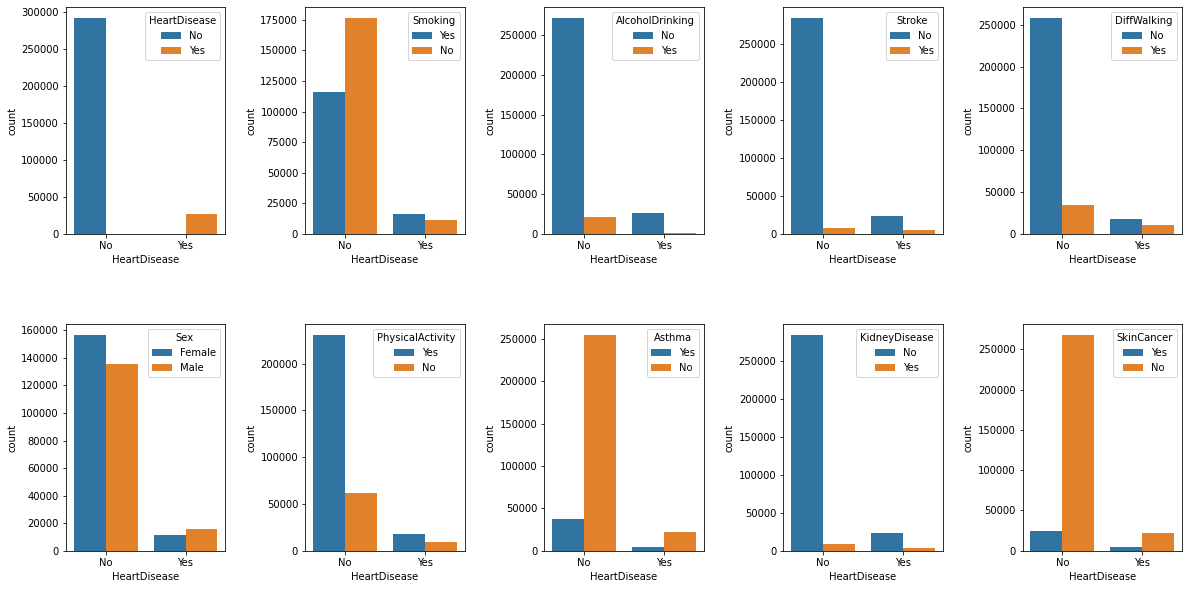

In [70]:
figs, axes = plt.subplots(nrows= 2 , ncols=5, figsize = (20, 10))

figs.subplots_adjust(hspace=0.4, wspace=0.5)

for i, item in enumerate(Binray_Features_YN):
  ax = axes[i//5][i%5]
  sns.countplot(data=df,x="HeartDisease",hue=item, ax = ax);

Next, we plot the categorical features with multiple distinct values. These features are obtained from the previously and are stored in the dictionly `MultiVar_Features`.

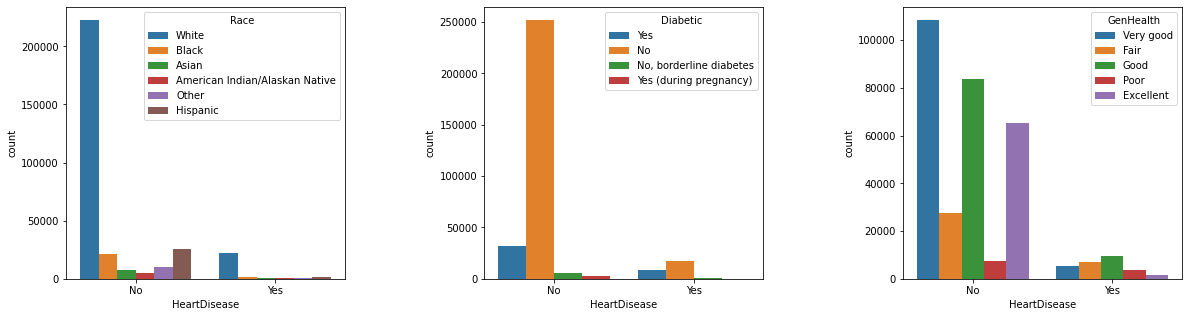

In [71]:
figs, axes = plt.subplots(nrows= 1 , ncols=3, figsize = (20, 5))

figs.subplots_adjust(hspace=0.4, wspace=0.5)
l = list(MultiVar_Features.keys())
l.remove("AgeCategory")
for i, item in enumerate(l):
  ax = axes[i]
  sns.countplot(data=df,x="HeartDisease",hue=item, ax = ax);

And finally we will plot the numerical features which are saved in `Numerical_features`.

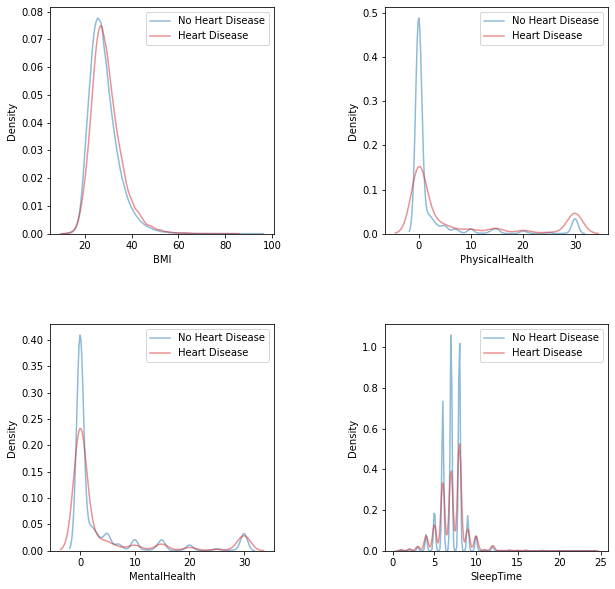

In [72]:
figs, axes = plt.subplots(nrows= 2 , ncols=2, figsize = (10, 10))

figs.subplots_adjust(hspace=0.4, wspace=0.5)

for i, item in enumerate(Numerical_features):
  
  ax = axes[i//2][i%2]
  sns.kdeplot(df.loc[df["HeartDisease"]== "No"][item], 
             color = "tab:blue", alpha = 0.5, label = "No Heart Disease", 
            ax = ax)
  sns.kdeplot(df.loc[df["HeartDisease"]== "Yes"][item], 
             color = "tab:red", alpha = 0.5, label = "Heart Disease",
             ax = ax)

  ax.legend();

It seems that `BMI` for the cases with heart disease and without heart disease have the same density. In order to see if `BMI` has an influence on the heart disease, we will plot its histogram as shown below

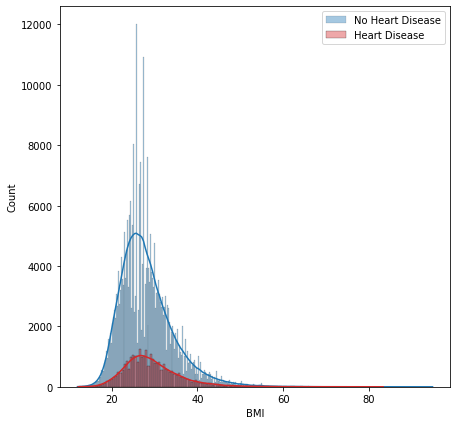

In [73]:
plt.figure(figsize=(7,7))
sns.histplot(df.loc[df["HeartDisease"]== "No"]["BMI"], 
             color = "tab:blue", alpha = 0.4, label = "No Heart Disease", 
            kde = True)
sns.histplot(df.loc[df["HeartDisease"]== "Yes"]["BMI"], 
             color = "tab:red", alpha = 0.4, label = "Heart Disease",
            kde = True)
# plt.show()
plt.legend();

# Data Preparation 

In this section, we are going to use `OneHotEncoder` to convert the categirical features itnot numerical values so thta we can use them in the rest of the modeling. One the other hand, if we check the numbera of cases that have heart diesease and the cases that do not have heart disease, we see that the data is highly imbalanced, so we need to use `SMOTE` to creat and balance the data

In [74]:
df["HeartDisease"].value_counts(normalize = True)*100

No     91.440454
Yes     8.559546
Name: HeartDisease, dtype: float64

In the next block, we will do the following in each step:

* **Step 1:** We will convert binary `Yes` and `No` values to `1` and `0`, respectively. Similarly, in this step, we convert `Female` to `1` and `Male` to `0`. Therefore, the values that we get when we are comparing the importance of the results, are for those with values equal to `1`. for example, we can interpret of `Sex` as `female?` and the results that we find can be interpreted as how being identified as female will affect the chance of getting heart disease. 

* **Step 2:** In this step we will use `OneHotEncoder` from `SKLearn` to convert the multivariable features into numerical value. We will enforce drop first to reduce the collinearity. 

* **Step 3:** In this step we will normalize our numerical features to reduce the cost of computation. We will use `StandardScaler` from `SKLearn`. 

* **Step 4:** We will concatenate the different dataframes that we found in ateps 1-3 to get a dataframe to be used when spliting into train and test sets.

* **Step 5:** The last step is resampling by using `SMOTE` to take care of the imbalances in the data.

In [75]:

df_2 = df.copy()

#### STEP 1: Converting Yes to 1 and No to 0, Female to 1 and Male to 0

Yes_No_dict = {"No":0, "Yes":1, "Female":1, "Male":0} 

Yes_No_List = list(Binray_Features_YN.keys())

Yes_No_List.remove("HeartDisease")


for col in Yes_No_List:
  
  df_2[col] = df_2[col].map(Yes_No_dict)
 


#### STEP @: Encoding By using OneHotEncoder

categorical = list(MultiVar_Features.keys())
df_2_cat = df_2[categorical].copy()


ohe = OneHotEncoder(categories='auto', sparse=False, drop="first")

df_2_cat_encoded = ohe.fit_transform(df_2_cat)
df_2_cat_encoded_df = pd.DataFrame( 
                                   np.squeeze(df_2_cat_encoded), 
                                   columns = ohe.get_feature_names()
                                   )



##### STEP 3: Scaling By using StandardScaler
scaler = StandardScaler()

numeric = list(Numerical_features.keys())
df_2_numeric = df_2[numeric].copy()


df_2_scaled_numeric = scaler.fit_transform(df_2_numeric) 
df_2_scaled_numeric_df = pd.DataFrame(
                                      np.squeeze(df_2_scaled_numeric), 
                                      columns = df_2_numeric.columns
                                      )


#### STEP 4: Concatating New DataFrames

df_2_ready = pd.concat([df_2[Yes_No_List],
                        df_2_cat_encoded_df, 
                        df_2_scaled_numeric_df],
                        axis = 1)



y = df_2["HeartDisease"].map({"Yes": 1, "No": 0})
X = df_2_ready
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    test_size = 0.2, 
                                                    stratify=y)


X_train_original = X_train.copy()
X_test_original = X_test.copy()
y_train_original = y_train.copy()
y_test_original = y_test.copy()


#### STEP 5: Using SMOTE to take care of the sample inbalances.
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Modeling

In this part, we will find a model to fit and predict our data. The metric that we will use is `recall` because we want to discover if a person will have a heart disease or not and it is important to find a model that has a higher recall score. 
In the section we will use the following methods to find a best model

1. **Decision Tree.** Our first model is *`DecisionTreeClassifier`* without tunning its hyperparameters. Then we will use *`GrdiSearchCV`* to find the best hyperparameters for our model.

2. **Random Forest.** We will use *`RandomForestClassifier`* as the second model to fit and predict the results. Initially we will not tune the hyperparameters and will fit the model, and after that we will use `RandomizedSearchCV` to find the best hyperparameters.

3. **Extreme Gradient Boosting.** We will use *`XGBClassifier`* as our last attempt to predict the data. Initially I woudl use this model without tunning the hyperparameters and after that we will use `RandomizedSearchCV` to find the best hyperparameters.

At the end, we will use the following approaches which are not part of the curriculum, but I would like to compare their results with the other approaches. These approaches are 

1. **LightGMB.** We will use *`LightGBMClassifier`* from *`LightGBM`* and we will compare its results with previous models.

2. **CatBoost.** We will use *`CatBoostClassifier`* from *`CatBoost`* and we will compare its results with previous models. The advantages of this method is that we do not need to use `OneHotEncoder` to convert the categorical features into numerical value. However, this brings us an issue which is we cannot use `SMOTE` to deal with the imbalances in the data.



## Decision Tree

The first model that we are going to train is Decision Tree. We will use *`DecisionTreeClassifier`* from `sklearn` and then we will tune its hyperparameters.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state = 42, criterion = "entropy", max_depth = 5)

tree_clf.fit(X_train_smote, y_train_smote)

test_preds_tree = tree_clf.predict(X_test)

print_results(test_preds_tree, y_test)

Results summaries are

Validation AUC is        : 0.6825
Test precision_score is  : 0.1743
Test recall_score is     : 0.6561
f1_score is              : 0.2754
----------------------------------------
The Classification Report is

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     58484
           1       0.17      0.66      0.28      5475

    accuracy                           0.70     63959
   macro avg       0.57      0.68      0.54     63959
weighted avg       0.89      0.70      0.77     63959

----------------------------------------
And Confusion Matrix is

[[41464 17020]
 [ 1883  3592]]


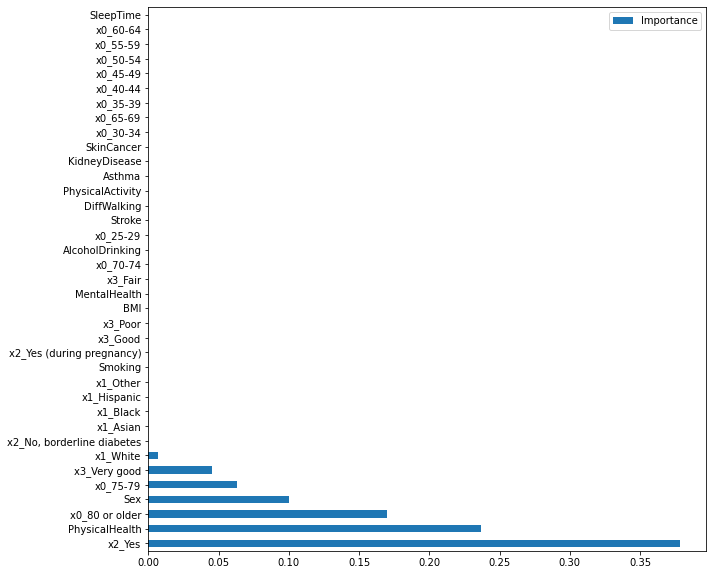

In [ ]:
import matplotlib.pyplot as plt

tree_feat_importances = pd.DataFrame(tree_clf.feature_importances_, 
                                index=X_train_smote.columns, columns=["Importance"])
tree_feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
tree_feat_importances.plot(kind='barh', figsize=(10,10));

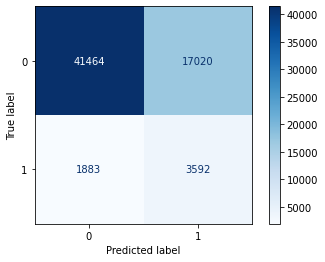

In [ ]:
# Visualize your confusion matrix
plot_confusion_matrix(tree_clf, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**Results** are 

```python
Validation AUC is        : 0.6825
Test precision_score is  : 0.1743
Test recall_score is     : 0.6561
f1_score is              : 0.2754
```

with the following classification report 

```python
                precision    recall  f1-score   support

           0       0.96      0.71      0.81     58484
           1       0.17      0.66      0.28      5475

    accuracy                           0.70     63959
   macro avg       0.57      0.68      0.54     63959
weighted avg       0.89      0.70      0.77     63959
```
and confusion matrix

```python
[[41464 17020]
 [ 1883  3592]]
 ```

**Results:**  We find the `auc` score as 0.6825266466354298. Now we will use gridsearch to find a better tuning parameters for the hyperprameters.

### Tunning Decision Tree

In [ ]:
tree_param_grid = {"max_depth": [5, 15, 20],
                  "min_samples_split": [2, 5, 6],
                  # "max_leaf_nodes": [2, 3],
                  "random_state" : [42], 
                  "criterion" : ["entropy", "gini"]
                  }

tree_grid = DecisionTreeClassifier()

tree_grid_search = GridSearchCV(tree_grid, tree_param_grid, cv = None)


# Fit to the data
tree_grid_search.fit(X_train_smote, y_train_smote)
test_preds_tree_grid = tree_grid_search.predict(X_test)

print_results(test_preds_tree_grid, y_test)

Results summaries are

Validation AUC is        : 0.6611
Test precision_score is  : 0.2296
Test recall_score is     : 0.4698
f1_score is              : 0.3084
----------------------------------------
The Classification Report is

              precision    recall  f1-score   support

           0       0.94      0.85      0.90     58484
           1       0.23      0.47      0.31      5475

    accuracy                           0.82     63959
   macro avg       0.59      0.66      0.60     63959
weighted avg       0.88      0.82      0.85     63959

----------------------------------------
And Confusion Matrix is

[[49854  8630]
 [ 2903  2572]]


In [ ]:
tree_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 5,
 'random_state': 42}

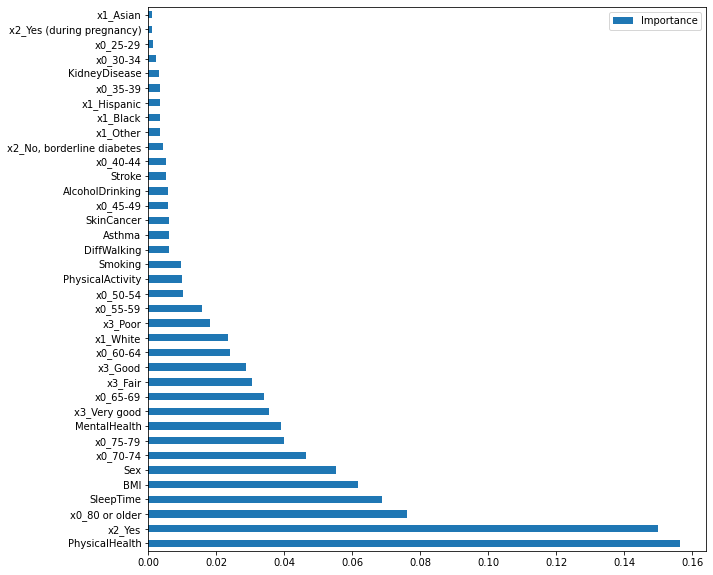

In [ ]:
import matplotlib.pyplot as plt

tree_grid_feat_importances = pd.DataFrame(tree_grid_search.best_estimator_.feature_importances_, 
                                index=X_train_smote.columns, columns=["Importance"])
tree_grid_feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
tree_grid_feat_importances.plot(kind='barh', figsize=(10,10));

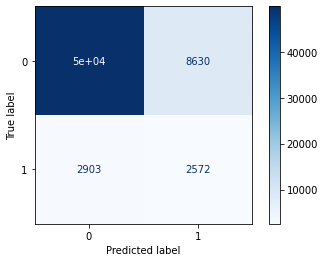

In [ ]:
# Visualize your confusion matrix
plot_confusion_matrix(tree_grid_search, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**Result**: By using the gride search we find `auc` as 0.6601 and the rest are

```python
Validation AUC is        : 0.6611
Test precision_score is  : 0.2296
Test recall_score is     : 0.4698
f1_score is              : 0.3084
```
and the classification report is

```python
               precision    recall  f1-score   support

           0       0.94      0.85      0.90     58484
           1       0.23      0.47      0.31      5475

    accuracy                           0.82     63959
   macro avg       0.59      0.66      0.60     63959
weighted avg       0.88      0.82      0.85     63959
```
and the confusion matrix is

```python
[[49854  8630]
 [ 2903  2572]]
 ```

and the best parameters are:

```python
{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 5,
 'random_state': 42}
 ```


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion="entropy", bootstrap = True)

rf.fit(X_train_smote, y_train_smote)

rf_preds = rf.predict(X_test)


print_results(rf_preds, y_test)

Results summaries are

Validation AUC is        : 0.6008
Test precision_score is  : 0.2534
Test recall_score is     : 0.2784
f1_score is              : 0.2653
----------------------------------------
The Classification Report is

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     58484
           1       0.25      0.28      0.27      5475

    accuracy                           0.87     63959
   macro avg       0.59      0.60      0.60     63959
weighted avg       0.87      0.87      0.87     63959

----------------------------------------
And Confusion Matrix is

[[53993  4491]
 [ 3951  1524]]


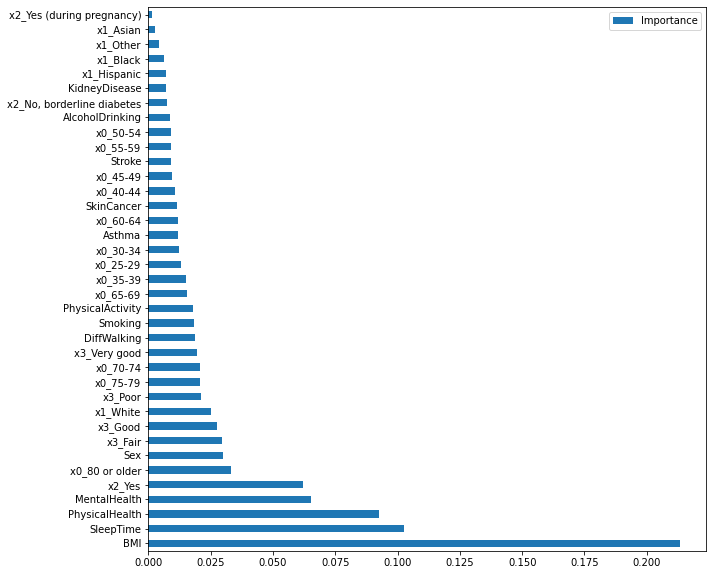

In [ ]:
import matplotlib.pyplot as plt

rf_feat_importances = pd.DataFrame(rf.feature_importances_, 
                                index=X_train_smote.columns, columns=["Importance"])
rf_feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
rf_feat_importances.plot(kind='barh', figsize=(10,10));

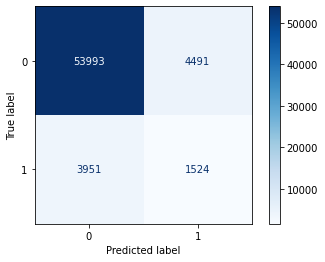

In [ ]:
# Visualize your confusion matrix
plot_confusion_matrix(rf, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**Results** are:

```python
Validation AUC is        : 0.6008
Test precision_score is  : 0.2534
Test recall_score is     : 0.2784
f1_score is              : 0.2653
```

the classification report is

```python
                precision    recall  f1-score   support

           0       0.93      0.92      0.93     58484
           1       0.25      0.28      0.27      5475

    accuracy                           0.87     63959
   macro avg       0.59      0.60      0.60     63959
weighted avg       0.87      0.87      0.87     63959

```

and the confusion matrix is

```python
[[53993  4491]
 [ 3951  1524]]
 ```



### RandomForest Model Tunning

In this part we will try to find the best parameters for our random forest by using `RandomizedSearchCV` to tune the hyperparameters.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

randomized_rf = RandomForestClassifier()

params = {"max_depth": [5, 10, 15, 20],
          "criterion":["gini", "entropy"], 
          "bootstrap" :[True],
          "max_leaf_nodes": [5, 10, 15, 20],
          "min_samples_split" : [2, 4, 6, 8]
          }

rf_tunned = RandomizedSearchCV(randomized_rf, params, cv = None,
                              random_state = 42)      


# Fit to the data
rf_tunned.fit(X_train_smote, y_train_smote)
test_preds_rf_tunned = rf_tunned.predict(X_test)

print_results(test_preds_rf_tunned, y_test)

Results summaries are

Validation AUC is        : 0.7359
Test precision_score is  : 0.2138
Test recall_score is     : 0.7195
f1_score is              : 0.3297
----------------------------------------
The Classification Report is

              precision    recall  f1-score   support

           0       0.97      0.75      0.85     58484
           1       0.21      0.72      0.33      5475

    accuracy                           0.75     63959
   macro avg       0.59      0.74      0.59     63959
weighted avg       0.90      0.75      0.80     63959

----------------------------------------
And Confusion Matrix is

[[44003 14481]
 [ 1536  3939]]


In [ ]:
rf_tunned.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_leaf_nodes': 20,
 'min_samples_split': 8}

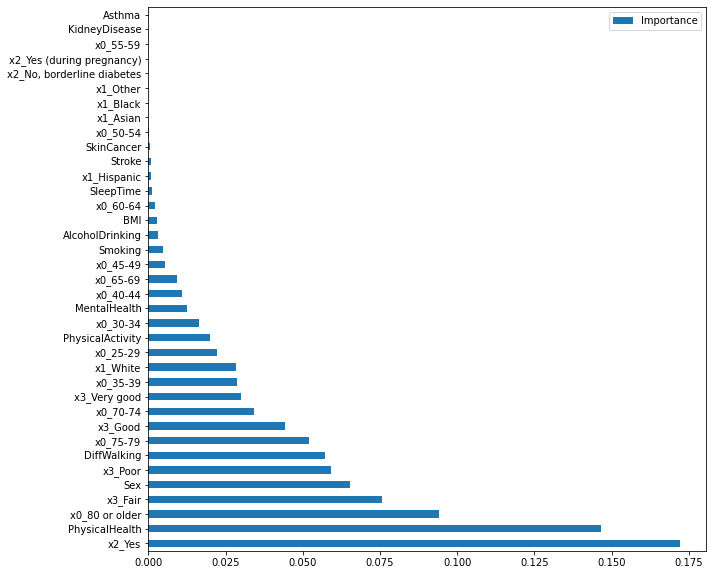

In [ ]:
import matplotlib.pyplot as plt

rf_tunned_feat_importances = pd.DataFrame(rf_tunned.best_estimator_.feature_importances_, 
                                index=X_train_smote.columns, columns=["Importance"])
rf_tunned_feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
rf_tunned_feat_importances.plot(kind='barh', figsize=(10,10));

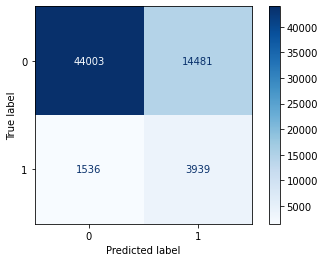

In [ ]:
# Visualize your confusion matrix
plot_confusion_matrix(rf_tunned, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**Results** of this tunning are as follows

```python
Validation AUC is        : 0.7359
Test precision_score is  : 0.2138
Test recall_score is     : 0.7195
f1_score is              : 0.3297
```

the classification report is 

```python
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     58484
           1       0.21      0.72      0.33      5475

    accuracy                           0.75     63959
   macro avg       0.59      0.74      0.59     63959
weighted avg       0.90      0.75      0.80     63959
```

and the confusion matrix is

```python
[[44003 14481]
 [ 1536  3939]]
```

and the best parameters are:

```python
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_leaf_nodes': 20,
 'min_samples_split': 8}
 ```

## XGBoost

The following Box is from [here](https://stackoverflow.com/questions/51587535/custom-evaluation-function-based-on-f1-for-use-in-xgboost-python-api) and also check [this](https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html)

or the first link is

```
https://stackoverflow.com/questions/51587535/custom-evaluation-function-based-on-f1-for-use-in-xgboost-python-api
```

and the second link is

```
https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html
```

In [ ]:
clf = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

clf.fit(X_train_smote, y_train_smote)

test_preds = clf.predict(X_test)

print_results(test_preds, y_test)

Results summaries are

Validation AUC is        : 0.7075
Test precision_score is  : 0.2492
Test recall_score is     : 0.5781
f1_score is              : 0.3482
----------------------------------------
The Classification Report is

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     58484
           1       0.25      0.58      0.35      5475

    accuracy                           0.81     63959
   macro avg       0.60      0.71      0.62     63959
weighted avg       0.89      0.81      0.85     63959

----------------------------------------
And Confusion Matrix is

[[48946  9538]
 [ 2310  3165]]


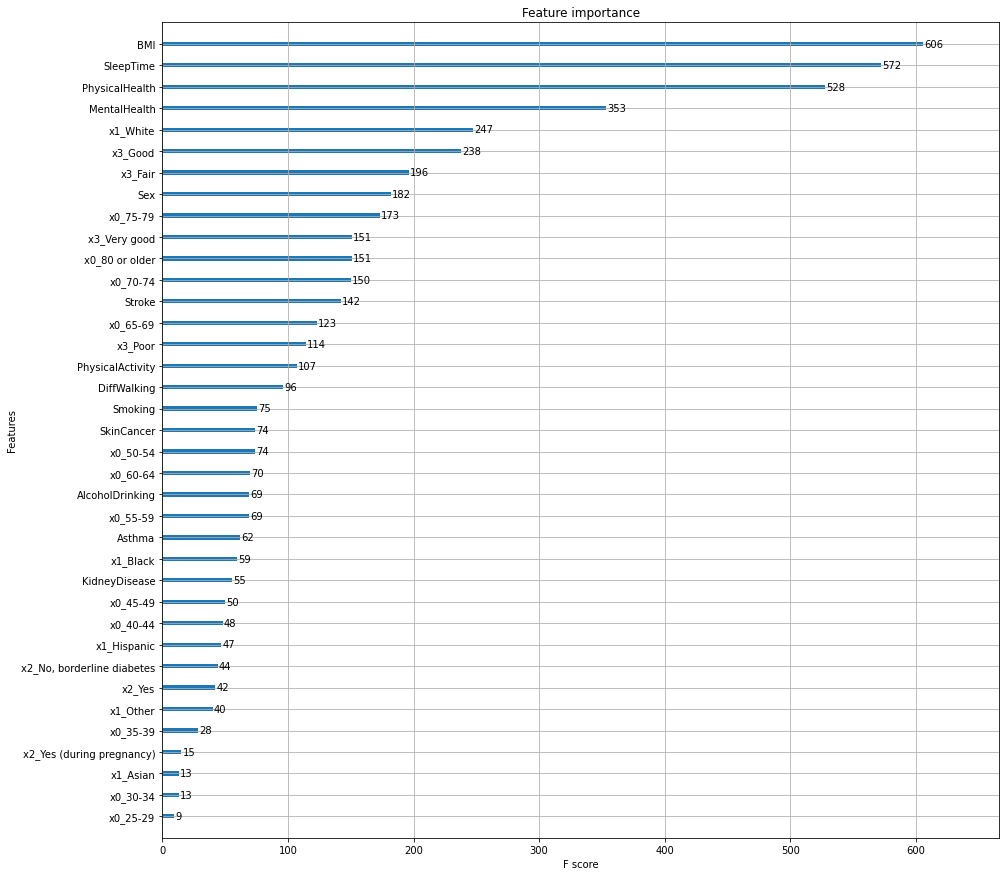

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))
xgb.plot_importance(clf, ax = ax);

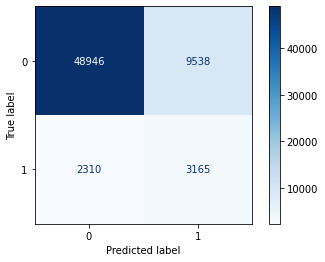

In [ ]:
# Visualize your confusion matrix
plot_confusion_matrix(clf, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**Results** are

```python
Validation AUC is        : 0.7075
Test precision_score is  : 0.2492
Test recall_score is     : 0.5781
f1_score is              : 0.3482
```

and classification report is

```python
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     58484
           1       0.25      0.58      0.35      5475

    accuracy                           0.81     63959
   macro avg       0.60      0.71      0.62     63959
weighted avg       0.89      0.81      0.85     63959
```

and confusion matrix is

```python
[[48946  9538]
 [ 2310  3165]]
```

### XGBoost Tunning


In [ ]:
xgb_param_grid = {
    "max_depth": [5, 10],
    "n_estimators": [10, 15],
    "seed": [42],
    "alpha": [10, 20, 25],
    "objective" : ['binary:logistic'], 
    "eval_metric" : ["auc"],
     "booster" : ['gbtree']
}

In [ ]:
xgb_grid = xgb.XGBClassifier()

xgb_grid_search = RandomizedSearchCV(xgb_grid, xgb_param_grid, cv = None)


xgb_grid_search.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(estimator=XGBClassifier(),
                   param_distributions={'alpha': [10, 20, 25],
                                        'booster': ['gbtree'],
                                        'eval_metric': ['auc'],
                                        'max_depth': [5, 10],
                                        'n_estimators': [10, 15],
                                        'objective': ['binary:logistic'],
                                        'seed': [42]})

In [ ]:
xgb_tunned_preds = xgb_grid_search.predict(X_test)

print_results(xgb_tunned_preds, y_test)

Results summaries are

Validation AUC is        : 0.7075
Test precision_score is  : 0.2492
Test recall_score is     : 0.5781
f1_score is              : 0.3482
----------------------------------------
The Classification Report is

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     58484
           1       0.25      0.58      0.35      5475

    accuracy                           0.81     63959
   macro avg       0.60      0.71      0.62     63959
weighted avg       0.89      0.81      0.85     63959

----------------------------------------
And Confusion Matrix is

[[48946  9538]
 [ 2310  3165]]


In [ ]:
xgb_grid_search.best_params_

{'alpha': 20,
 'booster': 'gbtree',
 'eval_metric': 'auc',
 'max_depth': 10,
 'n_estimators': 15,
 'objective': 'binary:logistic',
 'seed': 42}

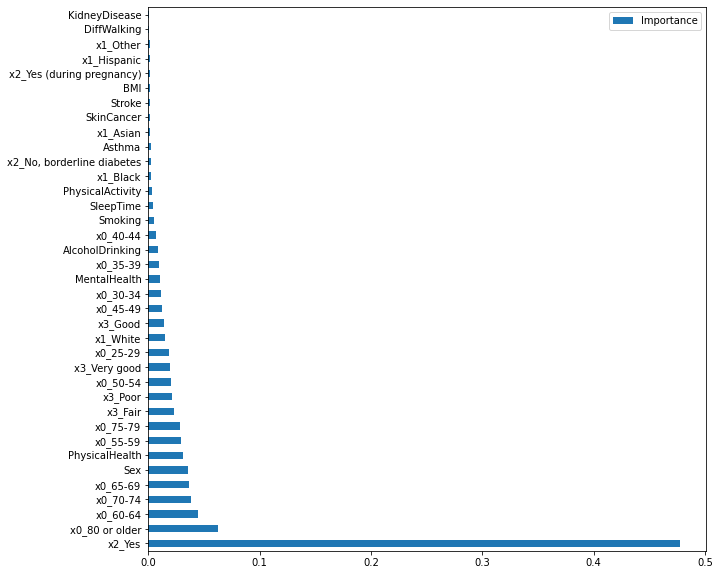

In [ ]:
import matplotlib.pyplot as plt

xgb_tunned_feat_importances = pd.DataFrame(
                          xgb_grid_search.best_estimator_.feature_importances_, 
                          index=X_train_smote.columns, 
                          columns=["Importance"]
                                          )

xgb_tunned_feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
xgb_tunned_feat_importances.plot(kind='barh', figsize=(10,10));

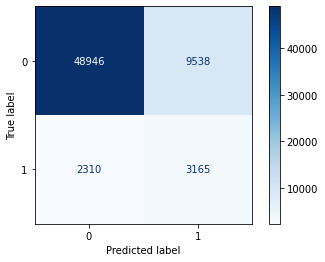

In [ ]:
# Visualize your confusion matrix
plot_confusion_matrix(xgb_grid_search, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**Results** are

```python
Validation AUC is        : 0.7075
Test precision_score is  : 0.2492
Test recall_score is     : 0.5781
f1_score is              : 0.3482
```

and classification report is

```python
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     58484
           1       0.25      0.58      0.35      5475

    accuracy                           0.81     63959
   macro avg       0.60      0.71      0.62     63959
weighted avg       0.89      0.81      0.85     63959
```

and confusion matrix is

```python
[[48946  9538]
 [ 2310  3165]]
 ```

 the best parameters are

 ```python 
 {'alpha': 20,
 'booster': 'gbtree',
 'eval_metric': 'auc',
 'max_depth': 10,
 'n_estimators': 15,
 'objective': 'binary:logistic',
 'seed': 42}
 ```



## LightGBM

In [59]:
import lightgbm as lgb

In [95]:
# num_boost_round=100
params = {'num_boost_round':100,
        'learning_rate':0.02,
        'objective' : 'binary',
        'feature_name' : list(X_train.columns),
        # 'cat_features': categorical,
        'depth':10,
        'eval_metric':'AUC',
        # 'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 42,
        'class_weight' :  'balanced'
          }

lgb_model = lgb.LGBMClassifier(**params)
lgb_model.fit(X_train_original, y_train_original,   
          eval_set=(X_test, y_test) );
 

[1]	valid_0's binary_logloss: 0.6873
[2]	valid_0's binary_logloss: 0.681708
[3]	valid_0's binary_logloss: 0.676342
[4]	valid_0's binary_logloss: 0.671194
[5]	valid_0's binary_logloss: 0.666256
[6]	valid_0's binary_logloss: 0.661532
[7]	valid_0's binary_logloss: 0.656886
[8]	valid_0's binary_logloss: 0.652434
[9]	valid_0's binary_logloss: 0.648146
[10]	valid_0's binary_logloss: 0.644036
[11]	valid_0's binary_logloss: 0.640065
[12]	valid_0's binary_logloss: 0.636258
[13]	valid_0's binary_logloss: 0.6327
[14]	valid_0's binary_logloss: 0.629252
[15]	valid_0's binary_logloss: 0.625948
[16]	valid_0's binary_logloss: 0.622577
[17]	valid_0's binary_logloss: 0.619335
[18]	valid_0's binary_logloss: 0.616423
[19]	valid_0's binary_logloss: 0.613488
[20]	valid_0's binary_logloss: 0.610562
[21]	valid_0's binary_logloss: 0.607871
[22]	valid_0's binary_logloss: 0.605255
[23]	valid_0's binary_logloss: 0.6027
[24]	valid_0's binary_logloss: 0.599961
[25]	valid_0's binary_logloss: 0.597595
[26]	valid_0's 

In [96]:
lgb_pred = lgb_model.predict(X_test)
lgb_pred
print_results(lgb_pred, y_test)

Results summaries are

Validation AUC is        : 0.7604
Test precision_score is  : 0.205
Test recall_score is     : 0.8177
f1_score is              : 0.3278
----------------------------------------
The Classification Report is

              precision    recall  f1-score   support

           0       0.98      0.70      0.82     58484
           1       0.20      0.82      0.33      5475

    accuracy                           0.71     63959
   macro avg       0.59      0.76      0.57     63959
weighted avg       0.91      0.71      0.78     63959

----------------------------------------
And Confusion Matrix is

[[41119 17365]
 [  998  4477]]


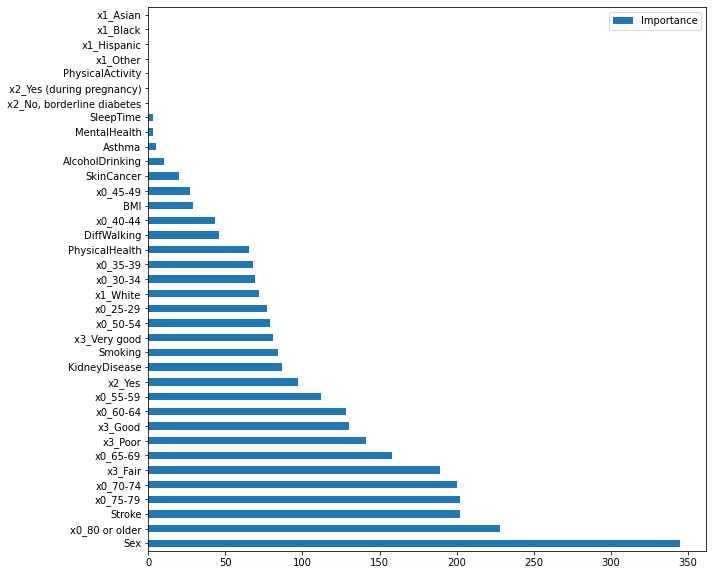

In [97]:
import matplotlib.pyplot as plt

lgb_importances = pd.DataFrame(lgb_model.feature_importances_, 
                                index=X_train.columns, columns=["Importance"])
lgb_importances.sort_values(by='Importance', ascending=False, inplace=True)
lgb_importances.plot(kind='barh', figsize=(10,10));

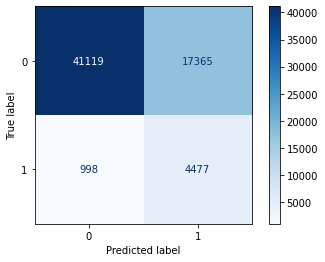

In [98]:

plot_confusion_matrix(lgb_model, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

Summary of Results are

```python 
Validation AUC is        : 0.7604
Test precision_score is  : 0.205
Test recall_score is     : 0.8177
f1_score is              : 0.3278
```
The Classification Report is
```python

              precision    recall  f1-score   support

           0       0.98      0.70      0.82     58484
           1       0.20      0.82      0.33      5475

    accuracy                           0.71     63959
   macro avg       0.59      0.76      0.57     63959
weighted avg       0.91      0.71      0.78     63959

```
And Confusion Matrix is

```python
[[41119 17365]
 [  998  4477]]
 ```

## CatBoost

In this part, I want to use `CatBoost` to model our data. First, I need to install it by using `! pip install catboost`

In [25]:
! pip install catboost

     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [26]:
from catboost import CatBoostClassifier

In order to use `CatBoost` we do not need to encode our categorical data and as a result we do not need to use `OneHotEncoder` because `CatBoost` by itself does it. However, we have to tell `catboost` which columns are categorical and which ones are `numerical`. to do so, we need to represent them by a numerical array. So, we will do the following data preparation. 

### Datar peparation and modeling with CatBoost

We will split our data into train and test sets as usual as:

In [43]:
cat_data = df.copy()
cat_data["HeartDisease"] = cat_data["HeartDisease"].map({"Yes": 1, "No":0})
yc = cat_data["HeartDisease"]
Xc = cat_data.drop("HeartDisease", axis = 1)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc,
                                                        random_state = 42,
                                                        test_size = 0.2)


# smote = SMOTE()
# Xc_smote, yc_smote = smote.fit_resample(Xc_train, yc_train)

Xc_categorical = list(Xc.select_dtypes(include=['object']).columns)
Xc_numerical   = list(Xc.select_dtypes(include=['int64', 'float64']).columns)

categorical = [Xc.columns.get_loc(i) for i in Xc_categorical]
numerical = [Xc.columns.get_loc(i) for i in Xc_numerical]


However, we cannot use `SMOTE` in the case because we have not used `OneHotEncoder` to convert the categorical features. So, in order to solve the class imbalance, we may use the following code and the we can pass the `class_weights` to `CatBoost`. The code is from [here](https://stackoverflow.com/questions/57565510/usage-of-class-weights-in-catboostclassifier) or

```
https://stackoverflow.com/questions/57565510/usage-of-class-weights-in-catboostclassifier
```

In [47]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(yc_train)
weights = compute_class_weight(class_weight='balanced',
                               classes=classes, y=yc_train)
class_weights = dict(zip(classes, weights))

In [56]:
class_weights

{0: 0.5465296618316208, 1: 5.872916762315779}

The link to the parameters that I used is [here](https://www.viralml.com/video-content.html?v=zKEPXQzqxe0) or 

```
https://www.viralml.com/video-content.html?v=zKEPXQzqxe0
```

In [50]:
params = {'iterations':3000,
        'learning_rate':0.01,
        'cat_features': Xc_categorical,
        'depth':3,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 42,
        'class_weight' : class_weights
          }

cat_model = CatBoostClassifier(**params)
cat_model.fit(Xc_train, yc_train,   
          eval_set=(Xc_test, yc_test), 
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True  
         );
 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7787093	best: 0.7787093 (0)	total: 571ms	remaining: 28m 32s
200:	test: 0.8264854	best: 0.8264941 (198)	total: 37s	remaining: 8m 35s
400:	test: 0.8325860	best: 0.8325860 (400)	total: 1m 16s	remaining: 8m 18s
600:	test: 0.8352861	best: 0.8352861 (600)	total: 1m 58s	remaining: 7m 52s
800:	test: 0.8369534	best: 0.8369534 (800)	total: 2m 35s	remaining: 7m 5s
1000:	test: 0.8379155	best: 0.8379155 (1000)	total: 3m 10s	remaining: 6m 21s
1200:	test: 0.8385447	best: 0.8385447 (1200)	total: 3m 48s	remaining: 5m 42s
1400:	test: 0.8390714	best: 0.8390714 (1400)	total: 4m 36s	remaining: 5m 15s
1600:	test: 0.8393930	best: 0.8393930 (1600)	total: 5m 13s	remaining: 4m 33s
1800:	test: 0.8396671	best: 0.8396671 (1800)	total: 5m 50s	remaining: 3m 53s
2000:	test: 0.8398866	best: 0.8398866 (2000)	total: 6m 29s	remaining: 3m 14s
2200:	test: 0.8400165	best: 0.8400165 (2200)	total: 7m 8s	remaining: 2m 35s
2400:	test: 0.8401301	best: 0.8401301 (2400)	total: 7m 49s	remaining: 1m 57s
2600:	test: 0.8402

In [53]:
cat_pred = cat_model.predict(Xc_test)
cat_pred
print_results(cat_pred, yc_test)

Results summaries are

Validation AUC is        : 0.7653
Test precision_score is  : 0.2209
Test recall_score is     : 0.8015
f1_score is              : 0.3463
----------------------------------------
The Classification Report is

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     58367
           1       0.22      0.80      0.35      5592

    accuracy                           0.74     63959
   macro avg       0.60      0.77      0.59     63959
weighted avg       0.91      0.74      0.79     63959

----------------------------------------
And Confusion Matrix is

[[42558 15809]
 [ 1110  4482]]


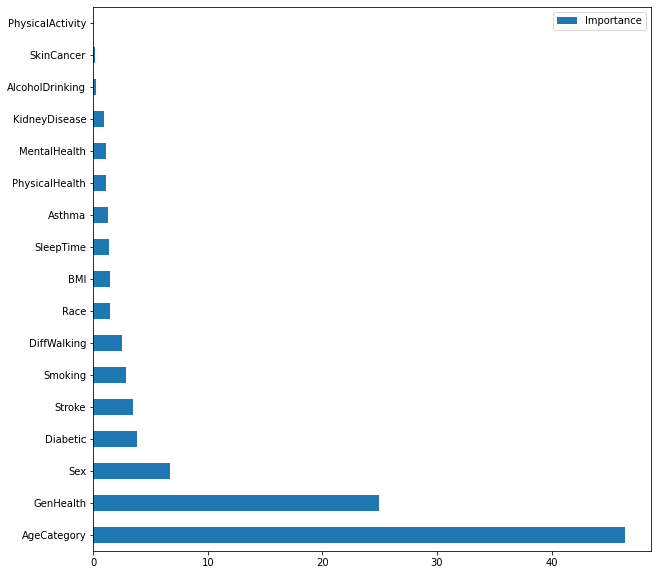

In [54]:
import matplotlib.pyplot as plt

cat_importances = pd.DataFrame(cat_model.feature_importances_, 
                                index=Xc_train.columns, columns=["Importance"])
cat_importances.sort_values(by='Importance', ascending=False, inplace=True)
cat_importances.plot(kind='barh', figsize=(10,10));

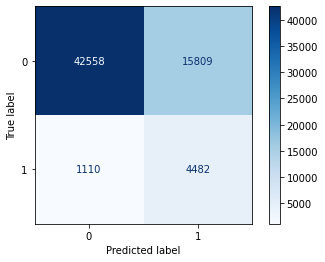

In [55]:
# Visualize your confusion matrix
plot_confusion_matrix(cat_model, Xc_test, yc_test,
                     cmap=plt.cm.Blues)
plt.show()

The results summaries are:

```python
Validation AUC is        : 0.7653
Test precision_score is  : 0.2209
Test recall_score is     : 0.8015
f1_score is              : 0.3463
```

The Classification Report is
```python
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     58367
           1       0.22      0.80      0.35      5592

    accuracy                           0.74     63959
   macro avg       0.60      0.77      0.59     63959
weighted avg       0.91      0.74      0.79     63959
```

And Confusion Matrix is

```python
[[42558 15809]
 [ 1110  4482]]
```

# Microsoft FLAML A Fast Library for Automated Machine Learning & Tuning

It can be found [here](https://github.com/microsoft/FLAML) or using the following link
```https://github.com/microsoft/FLAML```


In [ ]:
! pip install flaml

     |████████████████████████████████| 157 kB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 46.1 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
!pip install flaml[notebook]

     |████████████████████████████████| 757 kB 5.4 MB/s 
     |████████████████████████████████| 158 kB 41.8 MB/s 
  Created wheel for openml: filename=openml-0.10.2-py3-none-any.whl size=190318 sha256=37b9e0ed9d9d860b70cd07c8a5c1c64110799c3eb6d6db12da642020db8c6a2c
  Stored in directory: /root/.cache/pip/wheels/9c/9e/f3/6a5ebf16527d7fe22d9bc1652bc9beb5dc9fcfdeb75e805400
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=c3a85692cba865cd0871b68a0f09e310fd72d1dfcb7b629f6c3dfc536f2880f4
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built openml liac-arff


In [ ]:
df_FLAML = df.copy()
df_FLAML["HeartDisease"] = df_FLAML["HeartDisease"].map({"No": 0 , "Yes": 1})

X_new = df_FLAML.drop("HeartDisease", axis = 1)
y_new = df_FLAML.HeartDisease


X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_new, y_new,
                                                           test_size = 0.2,
                                                           random_state = 42)

In [ ]:
from flaml import AutoML
automl_xgb = AutoML()
automl_xgb.fit(X_train_n, y_train_n, task="classification", metric = "roc_auc", estimator_list=['xgboost']);

[flaml.automl: 04-06 07:30:23] {2105} INFO - task = classification
[flaml.automl: 04-06 07:30:23] {2107} INFO - Data split method: stratified
[flaml.automl: 04-06 07:30:23] {2111} INFO - Evaluation method: holdout
[flaml.automl: 04-06 07:30:24] {2188} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 04-06 07:30:24] {2281} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl: 04-06 07:30:24] {2567} INFO - iteration 0, current learner xgboost
[flaml.automl: 04-06 07:30:25] {2698} INFO - Estimated sufficient time budget=79440s. Estimated necessary time budget=79s.
[flaml.automl: 04-06 07:30:25] {2750} INFO -  at 4.9s,	estimator xgboost's best error=0.2249,	best estimator xgboost's best error=0.2249
[flaml.automl: 04-06 07:30:25] {2567} INFO - iteration 1, current learner xgboost
[flaml.automl: 04-06 07:30:25] {2750} INFO -  at 5.2s,	estimator xgboost's best error=0.2249,	best estimator xgboost's best error=0.2249
[flaml.automl: 04-06 07:30:25] {2567} INFO - iteratio

In [ ]:
print(automl_xgb.model.estimator)

XGBClassifier(colsample_bylevel=0.6365746352162247,
              colsample_bytree=0.7678713438512011, grow_policy='lossguide',
              learning_rate=0.14214377842149892, max_depth=0, max_leaves=33,
              min_child_weight=2.87766064364065, n_estimators=80, n_jobs=-1,
              reg_alpha=0.009017314821080643, reg_lambda=0.09059605891731264,
              subsample=0.6343115633616213, tree_method='hist',
              use_label_encoder=False, verbosity=0)


The Best XGB parameters found by FLAML are

```python

XGBClassifier(colsample_bylevel=0.6365746352162247,
              colsample_bytree=0.7678713438512011, grow_policy='lossguide',
              learning_rate=0.14214377842149892, max_depth=0, max_leaves=33,
              min_child_weight=2.87766064364065, n_estimators=80, n_jobs=-1,
              reg_alpha=0.009017314821080643, reg_lambda=0.09059605891731264,
              subsample=0.6343115633616213, tree_method='hist',
              use_label_encoder=False, verbosity=0)

```              

# New XGBoost Based on FLAML

In [ ]:
params = {
              "colsample_bylevel" : 0.8490633393816673,
              "colsample_bytree" : 0.8501582165474667, 
              "grow_policy" :'lossguide',
              "learning_rate" : 0.052998640031981195, 
              "max_depth" : 0, 
              "max_leaves" : 279,
              "min_child_weight" : 4.05164716830016, 
              "n_estimators" : 231, 
              "n_jobs" : -1,
              "reg_alpha" : 0.011728535554234117, 
              "reg_lambda" : 0.8243892535277468,
              "subsample" : 0.7323612940065832, 
              "tree_method" : 'hist',
              "use_label_encoder" : False,
              "verbosity" : 0
}

Train_dmatrix = xgb.DMatrix(data = X_train_smote, label = y_train_smote)
Test_dmatrix = xgb.DMatrix(data = X_test, label = y_test)


cv_results = xgb.cv(dtrain=Train_dmatrix, params=params, nfold=4,
        num_boost_round=10, metrics="auc", as_pandas=True)
# second_xgb.fit(X_train_smote, y_train_smote, param = params)

In [ ]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.890022,0.002829,0.888325,0.002877
1,0.904830,0.001973,0.903215,0.002020
2,0.910435,0.002971,0.908744,0.002928
3,0.914635,0.000844,0.912965,0.001082
4,0.916420,0.001944,0.914730,0.002151
5,0.919043,0.002854,0.917336,0.003062
6,0.921328,0.002318,0.919674,0.002520
7,0.922951,0.001158,0.921346,0.001309
8,0.924660,0.000488,0.923070,0.000575
9,0.925989,0.001098,0.924378,0.000985


The cross Validation report is

```python
	train-auc-mean	   train-auc-std	  test-auc-mean	  test-auc-std
0	   0.890022	        0.002829	       0.888325	       0.002877
1	   0.904830		    0.001973		   0.903215		   0.002020
2	   0.910435		    0.002971		   0.908744		   0.002928
3	   0.914635		    0.000844		   0.912965		   0.001082
4	   0.916420		    0.001944		   0.914730		   0.002151
5	   0.919043		    0.002854		   0.917336		   0.003062
6	   0.921328		    0.002318		   0.919674		   0.002520
7	   0.922951		    0.001158		   0.921346		   0.001309
8	   0.924660		    0.000488		   0.923070		   0.000575
9	   0.925989		    0.001098		   0.924378		   0.000985
```

In [ ]:
FLAML_xgb = xgb.XGBClassifier(objective='binary:logistic', seed = 42, param = params)

In [ ]:
FLAML_xgb.fit(X_train_smote, y_train_smote)


XGBClassifier(param={'colsample_bylevel': 0.8490633393816673,
                     'colsample_bytree': 0.8501582165474667,
                     'grow_policy': 'lossguide',
                     'learning_rate': 0.052998640031981195, 'max_depth': 0,
                     'max_leaves': 279, 'min_child_weight': 4.05164716830016,
                     'n_estimators': 231, 'n_jobs': -1,
                     'reg_alpha': 0.011728535554234117,
                     'reg_lambda': 0.8243892535277468,
                     'subsample': 0.7323612940065832, 'tree_method': 'hist',
                     'use_label_encoder': False, 'verbosity': 0},
              seed=42)

In [ ]:
xgb_FLAML_preds = FLAML_xgb.predict(X_test)

print_results(xgb_FLAML_preds, y_test)

Validation AUC: 0.7251
Test precision_score: 0.2589
Test recall_score: 0.6152
f1_score: 0.3644

[[48842  9642]
 [ 2107  3368]]

              precision    recall  f1-score   support

           0       0.96      0.84      0.89     58484
           1       0.26      0.62      0.36      5475

    accuracy                           0.82     63959
   macro avg       0.61      0.73      0.63     63959
weighted avg       0.90      0.82      0.85     63959



**Results** are:

```python
Validation AUC: 0.7251
Test precision_score: 0.2589
Test recall_score: 0.6152
f1_score: 0.3644

```

classification report is
```python
precision    recall  f1-score   support

           0       0.96      0.84      0.89     58484
           1       0.26      0.62      0.36      5475

    accuracy                           0.82     63959
   macro avg       0.61      0.73      0.63     63959
weighted avg       0.90      0.82      0.85     63959
```

confusion matrix is
```
[[48842  9642]
 [ 2107  3368]]
````


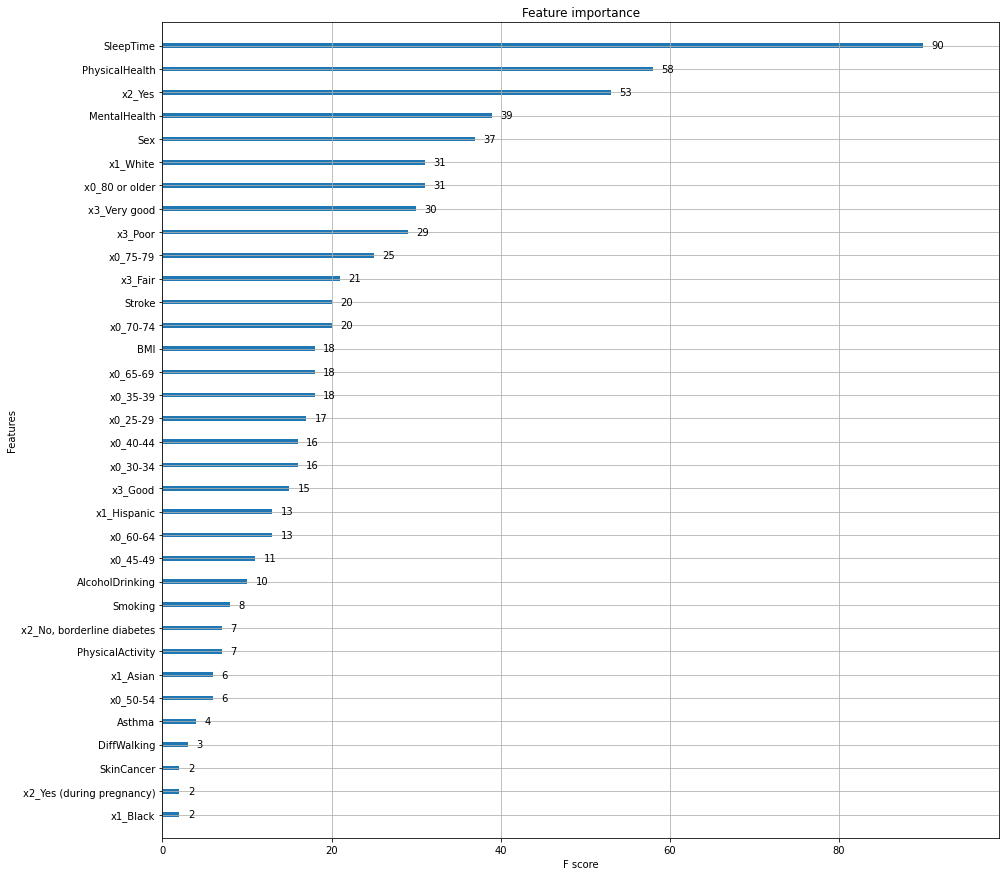

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))
xgb.plot_importance(FLAML_xgb, ax = ax);

# Using FLAML to find the Best RandomForest

In [ ]:
from flaml import AutoML
automl_rf = AutoML()
automl_rf.fit(X_train_n, y_train_n, task="classification", metric = "roc_auc", estimator_list=['rf']);

[flaml.automl: 04-06 07:57:23] {2105} INFO - task = classification
[flaml.automl: 04-06 07:57:23] {2107} INFO - Data split method: stratified
[flaml.automl: 04-06 07:57:23] {2111} INFO - Evaluation method: holdout
[flaml.automl: 04-06 07:57:24] {2188} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 04-06 07:57:24] {2281} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 04-06 07:57:24] {2567} INFO - iteration 0, current learner rf
[flaml.automl: 04-06 07:57:24] {2698} INFO - Estimated sufficient time budget=86655s. Estimated necessary time budget=87s.
[flaml.automl: 04-06 07:57:24] {2750} INFO -  at 1.8s,	estimator rf's best error=0.2681,	best estimator rf's best error=0.2681
[flaml.automl: 04-06 07:57:24] {2567} INFO - iteration 1, current learner rf
[flaml.automl: 04-06 07:57:24] {2750} INFO -  at 2.2s,	estimator rf's best error=0.2030,	best estimator rf's best error=0.2030
[flaml.automl: 04-06 07:57:24] {2567} INFO - iteration 2, current learner rf
[flaml.auto

In [ ]:
print(automl_rf.model.estimator)

RandomForestClassifier(criterion='entropy', max_features=0.2597547230915925,
                       max_leaf_nodes=52, n_estimators=52, n_jobs=-1)


Best marameters are

```python
RandomForestClassifier(criterion='entropy', max_features=0.2597547230915925,
                       max_leaf_nodes=52, n_estimators=52, n_jobs=-1)
```

In [ ]:
from sklearn.ensemble import RandomForestClassifier

FLAM_rf = RandomForestClassifier(criterion='entropy', max_features=0.2597547230915925,
                       max_leaf_nodes=52, n_estimators=52, n_jobs=-1)

FLAM_rf.fit(X_train_smote, y_train_smote)

test_preds_FLAM_rf     = FLAM_rf.predict(X_test)

print_results(test_preds_FLAML_rf, y_test)

Validation AUC: 0.7436
Test precision_score: 0.2157
Test recall_score: 0.7386
f1_score: 0.3338

[[43776 14708]
 [ 1431  4044]]

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     58484
           1       0.26      0.28      0.27      5475

    accuracy                           0.87     63959
   macro avg       0.59      0.60      0.60     63959
weighted avg       0.87      0.87      0.87     63959



**Results** are

```python
Validation AUC: 0.7436
Test precision_score: 0.2157
Test recall_score: 0.7386
f1_score: 0.3338
```
confusion matrix is

```python
[[43776 14708]
 [ 1431  4044]]
 ```

 and classification report is
 
 ```python
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     58484
           1       0.26      0.28      0.27      5475

    accuracy                           0.87     63959
   macro avg       0.59      0.60      0.60     63959
weighted avg       0.87      0.87      0.87     63959

```

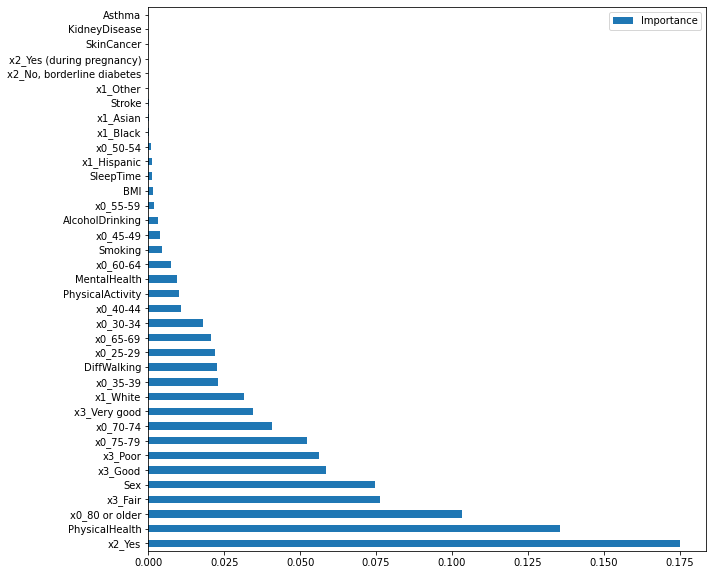

In [ ]:
import matplotlib.pyplot as plt

FLAM_rf_feat_importances = pd.DataFrame(FLAM_rf.feature_importances_, 
                                index=X_train_smote.columns, columns=["Importance"])
FLAM_rf_feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
FLAM_rf_feat_importances.plot(kind='barh', figsize=(10,10));